# 📊 Customer & Marketing Campaign Analysis Project

Table of Contents:

* Imports and Setup

* Data Loading

* Data Cleaning and Preprocessing

* Exploratory Data Analysis (EDA)

* Predictive Modeling: High-Performing Campaigns

* Summary and Future Work



In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

sns.set(style="whitegrid")
np.random.seed(42)

In [2]:
# Loading Blinkit datasets directly from Kaggle input path

orders = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_orders.csv', delimiter=',', encoding='ascii')
products = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_products.csv', delimiter=',', encoding='utf-8')
order_items = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_order_items.csv', delimiter=',', encoding='ascii')
feedback = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_customer_feedback.csv', delimiter=',', encoding='ascii')
marketing = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_marketing_performance.csv', delimiter=',', encoding='ascii')
customers = pd.read_csv('/kaggle/input/blinkit-marketing-and-customer-powerbi-dashbord/blinkit_customers.csv', delimiter=',', encoding='Windows-1252')

# Quick checks
for name, df in [('Orders', orders), ('Products', products), ('Order Items', order_items),
                 ('Feedback', feedback), ('Marketing', marketing), ('Customers', customers)]:
    print(f"{name} shape: {df.shape}")

Orders shape: (5000, 10)
Products shape: (268, 10)
Order Items shape: (5000, 4)
Feedback shape: (5000, 8)
Marketing shape: (5400, 11)
Customers shape: (2500, 11)


In [3]:
print(feedback.head())

   feedback_id    order_id  customer_id  rating  \
0      2234710  1961864118     30065862       4   
1      5450964  1549769649      9573071       3   
2       482108  9185164487     45477575       3   
3      4823104  9644738826     88067569       4   
4      3537464  5427684290     83298567       3   

                          feedback_text feedback_category sentiment  \
0         It was okay, nothing special.          Delivery   Neutral   
1              The order was incorrect.    App Experience  Negative   
2         It was okay, nothing special.    App Experience   Neutral   
3      The product met my expectations.    App Experience   Neutral   
4  Product was damaged during delivery.          Delivery  Negative   

  feedback_date  
0    2024-07-17  
1    2024-05-28  
2    2024-09-23  
3    2023-11-24  
4    2023-11-20  


In [4]:
# Convert date fields
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')
orders['promised_delivery_time'] = pd.to_datetime(orders['promised_delivery_time'], errors='coerce')
orders['actual_delivery_time'] = pd.to_datetime(orders['actual_delivery_time'], errors='coerce')
orders['delivery_delayed'] = (orders['actual_delivery_time'] > orders['promised_delivery_time']).astype(int)

feedback['feedback_date'] = pd.to_datetime(feedback['feedback_date'], errors='coerce')
marketing['date'] = pd.to_datetime(marketing['date'], errors='coerce')
customers['registration_date'] = pd.to_datetime(customers['registration_date'], errors='coerce')

# Missing value inspection
print("Orders missing:\n", orders.isnull().sum())
print("Marketing missing:\n", marketing.isnull().sum())


Orders missing:
 order_id                  0
customer_id               0
order_date                0
promised_delivery_time    0
actual_delivery_time      0
delivery_status           0
order_total               0
payment_method            0
delivery_partner_id       0
store_id                  0
delivery_delayed          0
dtype: int64
Marketing missing:
 campaign_id          0
campaign_name        0
date                 0
target_audience      0
channel              0
impressions          0
clicks               0
conversions          0
spend                0
revenue_generated    0
roas                 0
dtype: int64


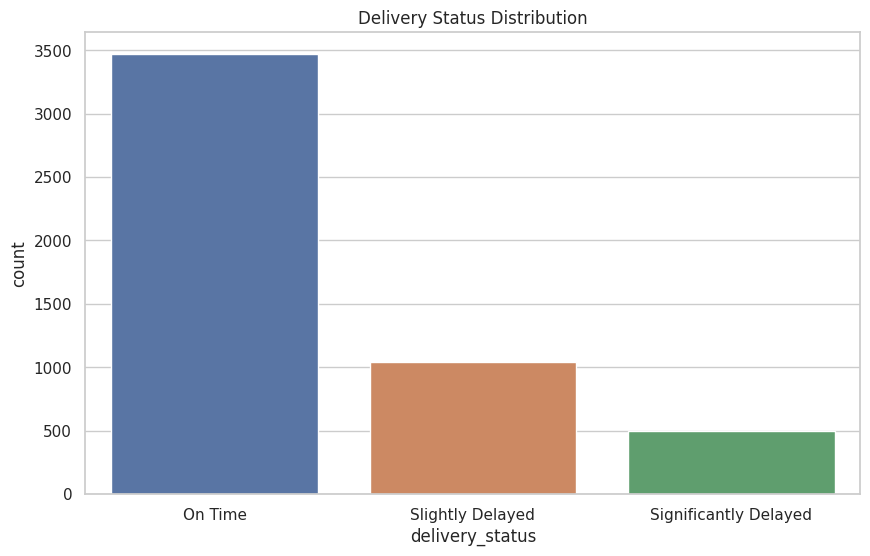

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='delivery_status', data=orders)
plt.title('Delivery Status Distribution')
plt.show()


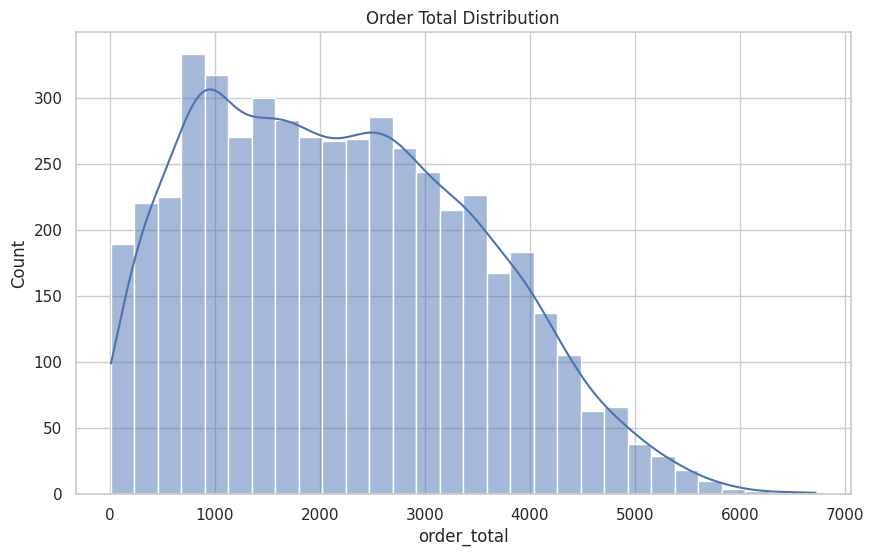

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(orders['order_total'], bins=30, kde=True)
plt.title('Order Total Distribution')
plt.show()


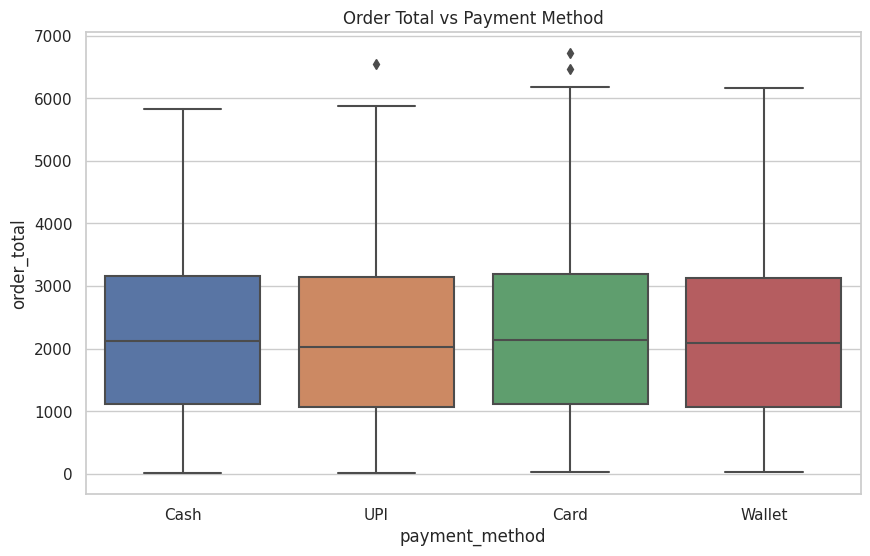

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_method', y='order_total', data=orders)
plt.title('Order Total vs Payment Method')
plt.show()


In [8]:
median_conv = marketing['conversions'].median()
marketing['high_conversion'] = (marketing['conversions'] > median_conv).astype(int)


In [9]:
features = ['impressions', 'clicks', 'spend', 'revenue_generated', 'roas']
target = 'high_conversion'
marketing_clean = marketing.dropna(subset=features + [target])

X = marketing_clean[features]
y = marketing_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5111111111111111


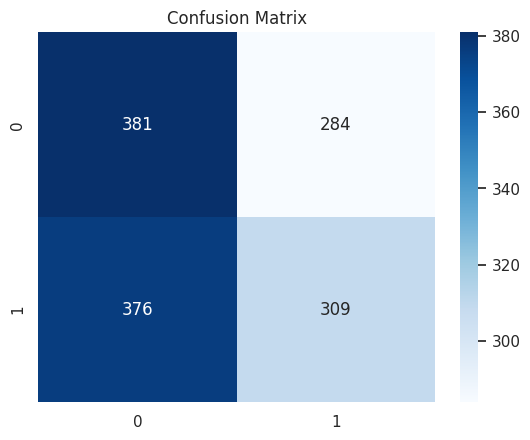

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


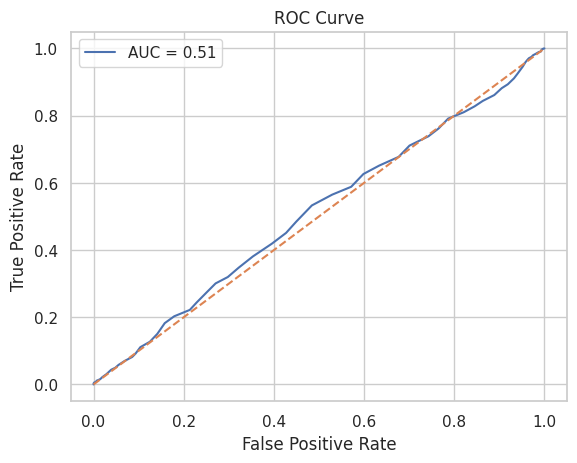

In [11]:
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 🧠 Summary 

* Loaded and merged multiple customer and campaign datasets.
* Cleaned and converted date values appropriately.
* Performed EDA on delivery performance and campaign metrics.
* Built a Random Forest model to predict high-performing marketing campaigns.

# Moving towards churn prediction and analysis

In [12]:
# Merge customers with their order history
customer_orders = orders[['customer_id', 'order_date']].copy()

# Get last order date for each customer
last_order = customer_orders.groupby('customer_id')['order_date'].max().reset_index()
last_order.columns = ['customer_id', 'last_order_date']

# Merge with customer base
customers_churn = customers[['customer_id', 'registration_date']].copy()
customers_churn = customers_churn.merge(last_order, on='customer_id', how='left')

# Define a reference date (last date in dataset or analysis date)
reference_date = orders['order_date'].max()

# Calculate days since last order
customers_churn['days_since_last_order'] = (reference_date - customers_churn['last_order_date']).dt.days

# Define churn threshold — e.g., no order in last 60 days = churned
churn_threshold = 60
customers_churn['churned'] = (customers_churn['days_since_last_order'] > churn_threshold).astype(int)

# Preview
customers_churn[['customer_id', 'last_order_date', 'days_since_last_order', 'churned']].head()


,customer_id,last_order_date,days_since_last_order,churned
0,97475543,2024-07-12 09:59:18,115.0,1
1,22077605,2024-03-07 08:59:56,242.0,1
2,47822591,2023-04-30 19:35:17,554.0,1
3,79726146,2023-09-19 00:26:15,412.0,1
4,57102800,2024-08-03 07:23:35,93.0,1


In [13]:
# Total orders per customer
order_counts = orders.groupby('customer_id')['order_id'].count().reset_index()
order_counts.columns = ['customer_id', 'total_orders']

# Average order value
avg_order_value = orders.groupby('customer_id')['order_total'].mean().reset_index()
avg_order_value.columns = ['customer_id', 'avg_order_value']

# Average delivery delay (in minutes)
orders['delivery_delay_mins'] = (orders['actual_delivery_time'] - orders['promised_delivery_time']).dt.total_seconds() / 60
avg_delay = orders.groupby('customer_id')['delivery_delay_mins'].mean().reset_index()
avg_delay.columns = ['customer_id', 'avg_delivery_delay']

# Feedback count per customer
feedback_counts = feedback.groupby('customer_id')['feedback_id'].count().reset_index()
feedback_counts.columns = ['customer_id', 'feedback_count']

# Average feedback rating
avg_rating = feedback.groupby('customer_id')['rating'].mean().reset_index()
avg_rating.columns = ['customer_id', 'avg_feedback_rating']

# Customer registration age
customers_churn['registration_age_days'] = (reference_date - customers_churn['registration_date']).dt.days


In [14]:
# Merge features into customers_churn
features = [order_counts, avg_order_value, avg_delay, feedback_counts, avg_rating]

for f in features:
    customers_churn = customers_churn.merge(f, on='customer_id', how='left')

# Fill missing values
customers_churn.fillna({
    'total_orders': 0,
    'avg_order_value': 0,
    'avg_delivery_delay': 0,
    'feedback_count': 0,
    'avg_feedback_rating': 0
}, inplace=True)

# Final preview
customers_churn.head()


,customer_id,registration_date,last_order_date,days_since_last_order,churned,registration_age_days,total_orders,avg_order_value,avg_delivery_delay,feedback_count,avg_feedback_rating
0,97475543,2023-05-13,2024-07-12 09:59:18,115.0,1,541,4.0,3078.9775,9.000000,4.0,3.000000
1,22077605,2024-06-18,2024-03-07 08:59:56,242.0,1,139,2.0,1324.2750,11.500000,2.0,3.500000
2,47822591,2024-09-25,2023-04-30 19:35:17,554.0,1,40,1.0,3090.8600,10.000000,1.0,3.000000
3,79726146,2023-10-04,2023-09-19 00:26:15,412.0,1,397,1.0,3415.3900,3.000000,1.0,4.000000
4,57102800,2024-03-22,2024-08-03 07:23:35,93.0,1,227,3.0,1198.0500,9.666667,3.0,4.333333


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Features and target
feature_cols = ['total_orders', 'avg_order_value', 'avg_delivery_delay',
                'feedback_count', 'avg_feedback_rating', 'registration_age_days']
X = customers_churn[feature_cols]
y = customers_churn['churned']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [16]:
# Initialize and train
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.42      0.56       206
           1       0.77      0.96      0.86       419

    accuracy                           0.79       625
   macro avg       0.81      0.69      0.71       625
weighted avg       0.80      0.79      0.76       625



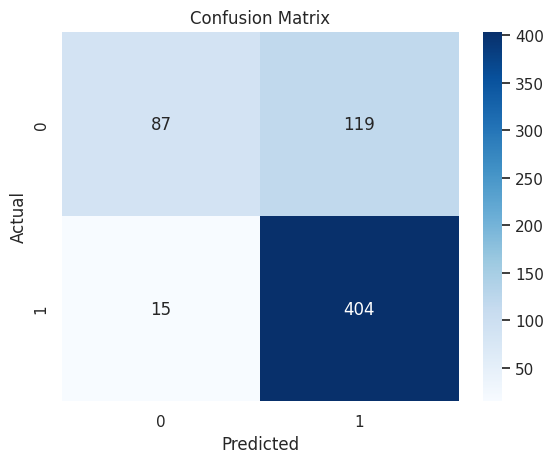

ROC AUC Score: 0.7334499617675001


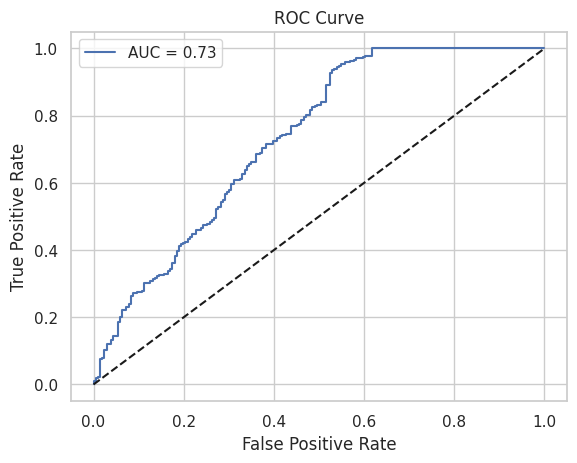

In [17]:
# Accuracy, precision, recall, F1
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.46      0.60       206
           1       0.78      0.96      0.87       419

    accuracy                           0.80       625
   macro avg       0.82      0.71      0.73       625
weighted avg       0.81      0.80      0.78       625

Random Forest ROC AUC Score: 0.7685601408809695


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.46      0.60       206
           1       0.78      0.96      0.87       419

    accuracy                           0.80       625
   macro avg       0.82      0.71      0.73       625
weighted avg       0.81      0.80      0.78       625



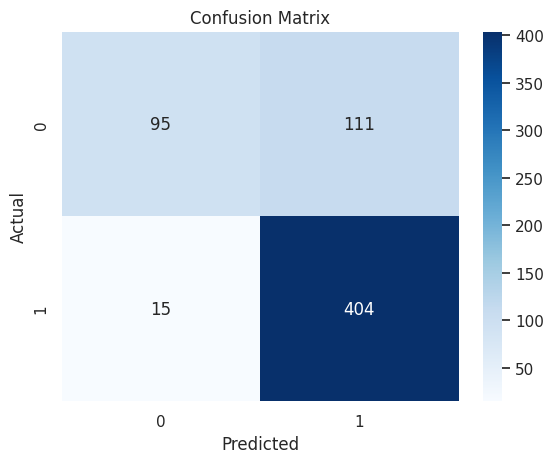

In [19]:
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
from xgboost import XGBClassifier

# Initialize and train
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.49      0.59       206
           1       0.78      0.92      0.85       419

    accuracy                           0.78       625
   macro avg       0.77      0.70      0.72       625
weighted avg       0.78      0.78      0.76       625

XGBoost ROC AUC Score: 0.7712190374678499


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.49      0.59       206
           1       0.78      0.92      0.85       419

    accuracy                           0.78       625
   macro avg       0.77      0.70      0.72       625
weighted avg       0.78      0.78      0.76       625



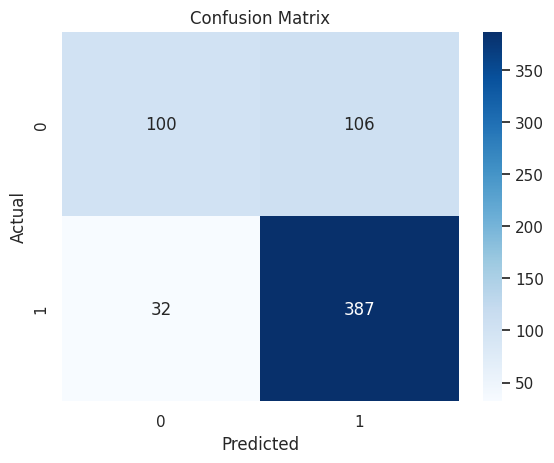

In [21]:
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

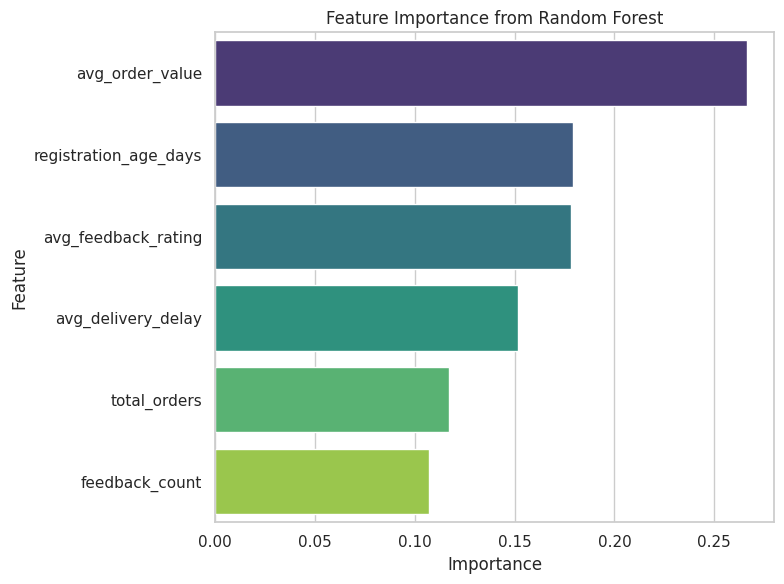

In [22]:
# Feature importance from Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort and plot
import pandas as pd
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


# The most important features driving churn were:

1. Average Order Value: Blinkit can add more options from different vendors with flexible price range.
2. Total Orders: Lower order frequency correlated with churn.Average
3. Feedback Rating: Customers with poor feedback ratings were more likely to churn.
4. Average Delivery Delay: Delays in delivery increased churn risk.
